## Deep Lerning Project - Speed Command Classification

In [39]:
import os
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
# from torchsummary import summary
import numpy as np
import torch

In [40]:
from torchsummary import summary

###### Construct Annotations file

In [41]:
import os, glob

path = "D:/2022-23 Academic Year/M2 Proba & Finance/S1/Machine Learning/Deep Learning Project/speech_commands_v0.01.tar/speech_commands_v0.01/"
# path = "D:/2022"
data_extension = "DATA/"
plot_extension = "PLOTS/"
start_cat = len(path+data_extension)

# ID = 0
# LABEL_ID = 0
# df = pd.DataFrame(columns = ['ID', 'FILENAME', 'FOLD', 'CLASS', 'LABEL'])
# classes = np.array([])
# for category_file in glob.glob(os.path.join(path+data_extension+"*/"), recursive=True):
#     category = category_file[start_cat:-1]
#     start = len(path+data_extension+category) + 1
#     for filename in glob.glob(os.path.join(path+data_extension+category, '*.wav')):
#         ID += 1
#         df = df.append({'ID' : ID,
#                         'FILENAME' : filename[start::],
#                         'FOLD' : category + "/",
#                        'CLASS' : category,
#                        'LABEL' : LABEL_ID},
#                        ignore_index = True)
#     classes = np.append(classes, category)
#     LABEL_ID += 1
# df.to_csv(path_or_buf=path+"ANNOTATIONS.csv", sep=',', index=False)

In [42]:
df = pd.read_csv(path+"ANNOTATIONS.csv")

In [43]:
df.head()

,ID,FILENAME,FOLD,CLASS,LABEL
0,1,00176480_nohash_0.wav,bed/,bed,0
1,2,004ae714_nohash_0.wav,bed/,bed,0
2,3,004ae714_nohash_1.wav,bed/,bed,0
3,4,00f0204f_nohash_0.wav,bed/,bed,0
4,5,00f0204f_nohash_1.wav,bed/,bed,0


In [44]:
classes = df['CLASS'].unique()

#### I/ Data Illustrations

In [45]:
def plot_signals_time(titles, signals):
    nrows, ncols = 5, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=(18, 13))
    
    z = 0
    for i in range(nrows):
        for y in range(ncols):
            ax[i,y].set_title(titles[z])
            ax[i,y].plot(signals[z])
            ax[i,y].set_xticks([])
            ax[i,y].set_yticks([])
            ax[i,y].grid(False)
            z += 1
    plt.show()
    return fig

In [46]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/20),
                       min_periods=1,
                       center=True).max()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask, y_mean

In [47]:
import librosa
import librosa.display
import IPython.display as ipd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [48]:
# Example of audio file
path = "D:/2022-23 Academic Year/M2 Proba & Finance/S1/Machine Learning/Deep Learning Project/speech_commands_v0.01.tar/speech_commands_v0.01/"
data_extension = "DATA/"
category = "bed/"
filename = "00f0204f_nohash_1.wav"

audio_files = glob.glob(path+data_extension+category+filename)
ipd.Audio(audio_files[0])

###### Periodogram

In [49]:
class_id = np.array([])
class_series = list(df['CLASS'])
for class_item in classes: 
    class_id = np.append(class_id ,class_series.index(class_item))

In [50]:
signal = []
signal_enveloppe = []
threshold = 10
sample_rate = 22050

for j in class_id: 
    filename = df['FILENAME'][j]
    category = df['FOLD'][j]
    audio_files = glob.glob(path+data_extension+category+filename)
    y, sample_rate = librosa.load(audio_files[0])
    y = pd.Series(y)
    signal.append(y)
    _, y_enveloppe = envelope(y, sample_rate, threshold)
    signal_enveloppe.append(y_enveloppe)
titles = classes

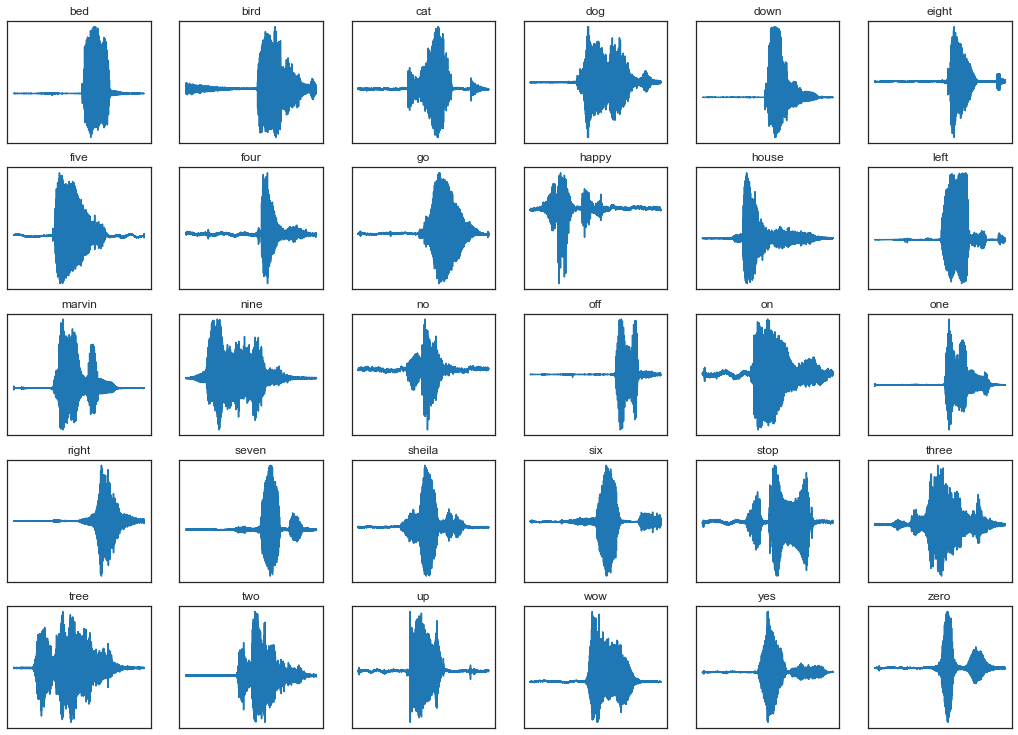

In [51]:
figure1 = plot_signals_time(titles, signal)
savename = path+plot_extension+"Figure1.pdf"  
figure1.savefig(savename, bbox_inches='tight')

###### Signal Envelope

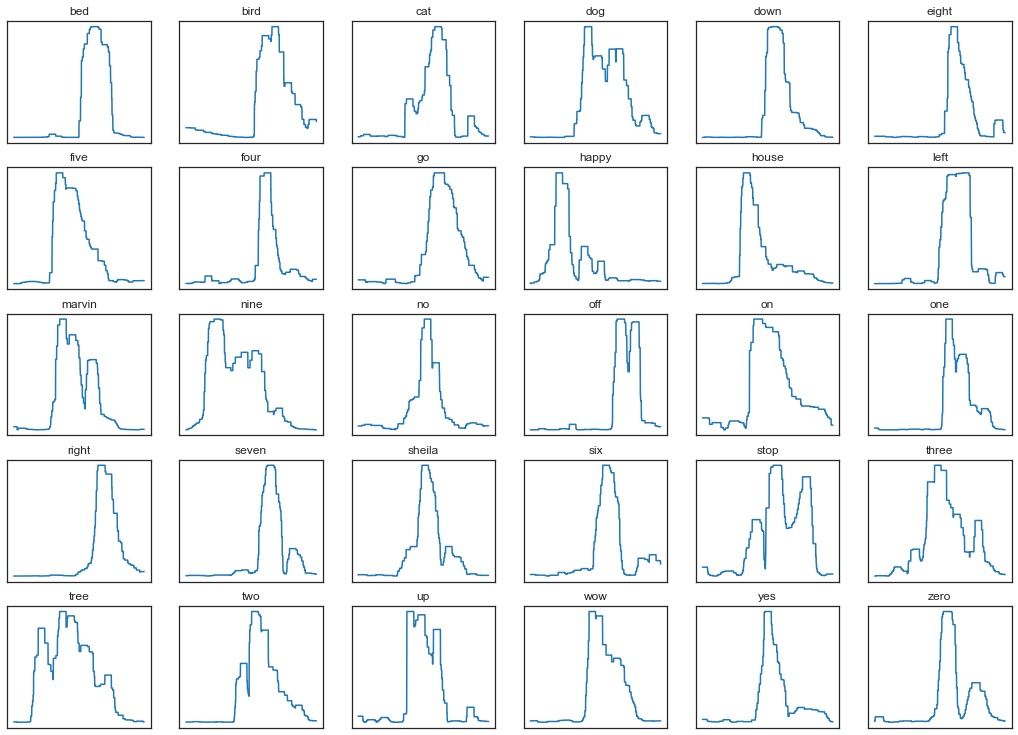

In [52]:
figure2 = plot_signals_time(titles, signal_enveloppe)
savename = path+plot_extension+"Figure2.pdf"  
figure2.savefig(savename, bbox_inches='tight')

###### Frequency Domain

In [53]:
def plot_signals_frequency(titles, signals):
    nrows, ncols = 5, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=(18, 13))
    
    z = 0
    for i in range(nrows):
        for y in range(ncols):
            ax[i,y].set_title(titles[z])
            signal = np.array(signals[z])
            fft = np.fft.rfft(signal)
            ax[i,y].plot(np.abs(fft)/np.sum(np.abs(fft)))
            ax[i,y].set_xticks([])
            ax[i,y].set_yticks([])
            ax[i,y].grid(False)
            z += 1
    plt.show()
    return fig

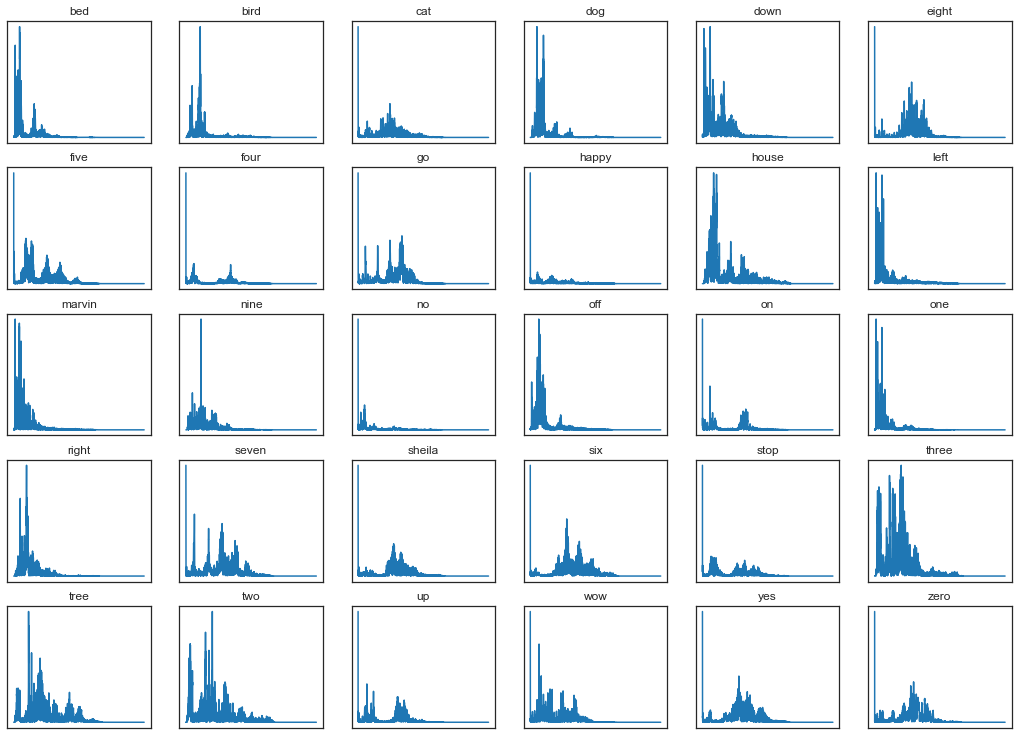

In [54]:
figure3 = plot_signals_frequency(titles, signal)
savename = path+plot_extension+"Figure3.pdf"  
figure3.savefig(savename, bbox_inches='tight')

###### Spectrogram

In [55]:
def specgram_librosa(segment, rate, ax, win_length=256, hop_length=64):
    D = librosa.stft(segment, hop_length=hop_length, win_length=win_length)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db,
                                   sr=rate,
                                   x_axis='s',
                                   y_axis='linear',
                                   ax=ax)

    return img

In [56]:
def mel_specgram_librosa(segment, rate, ax, win_length=256, hop_length=64):
    S = librosa.feature.melspectrogram(y=y,
                                   sr=sample_rate,
                                   n_mels=128 * 2,)
    S_db_mel = librosa.amplitude_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_db_mel,
                                   sr=rate,
                                   x_axis='s',
                                   y_axis='linear',
                                   ax=ax)

    return img

In [57]:
nrows, ncols = 5, 6

In [58]:
# fig, ax = plt.subplots(nrows, ncols, figsize=(30, 25))
# ax = ax.flatten()
# plt.subplots_adjust(hspace=0.5, wspace=0.4)
# plt.suptitle('Example of spectrograms of classes \n \n', fontweight='bold', size=20)

# for i in range (0, nrows * ncols):
#     y = np.array(signal[i])
#     ax[i].set_title(classes[i], fontweight='bold', size=15)
#     img = specgram_librosa(y, sample_rate, ax[i])
#     fig.colorbar(img, ax=ax[i], format="%+2.f dB")
#     fig.tight_layout()
# plt.show()

In [59]:
# savename = path+plot_extension+"Figure4.pdf"  
# fig.savefig(savename, bbox_inches='tight')

###### Mel-Spectrogram

In [60]:
# fig, ax = plt.subplots(nrows, ncols, figsize=(30, 25))
# ax = ax.flatten()
# plt.subplots_adjust(hspace=0.5, wspace=0.4)
# plt.suptitle('Example of Mel-spectrograms of classes \n \n', fontweight='bold', size=20)

# for i in range (0, nrows * ncols):
#     y = np.array(signal[i])
#     ax[i].set_title(classes[i], fontweight='bold', size=15)
#     img = mel_specgram_librosa(y, sample_rate, ax[i])
#     fig.colorbar(img, ax=ax[i], format="%+2.f dB")
#     fig.tight_layout()
# plt.show()

In [61]:
# savename = path+plot_extension+"Figure5.pdf"  
# fig.savefig(savename, bbox_inches='tight')

#### II/ Model

###### Load and prepare the data

In [62]:
class CommandRecognitionDataSet(Dataset):
    
    def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sample_rate = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sample_rate)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal) # extract mel-spectrogram
        return signal, label
    
    def _cut_if_necessary(self, signal):
        """select th appropriate duration of our audio file"""
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal
    
    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal
    
    def _resample_if_necessary(self, signal, sample_rate):
        if sample_rate != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, self.target_sample_rate)
            signal = resampler(signal)
        return signal
        
    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
        
    def _get_audio_sample_path(self, index):
        fold = f"{self.annotations.iloc[index, 2]}" # 5 is the number of the column with name of the folder
        filename = self.annotations.iloc[index, 1] # column with names of files
        path = os.path.join(self.audio_dir, fold, filename)
        return path
    
    def _get_audio_sample_label(self, index):
        label = self.annotations.iloc[index, 4] # index of the class id
        return label

In [63]:
DATA_PATH = path
ANNOTATIONS_FILE = DATA_PATH + "ANNOTATIONS.csv"
AUDIO_DIR = DATA_PATH + data_extension
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050
    
if torch.cuda.is_available():
    device ="cuda"
else:
    device = "cpu"
print(f"Using device: {device}")
    
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = SAMPLE_RATE,
    n_fft = 1024,
    hop_length = 512,
    n_mels = 64
)
    
crd = CommandRecognitionDataSet(ANNOTATIONS_FILE,
                                    AUDIO_DIR,
                                    mel_spectrogram,
                                    SAMPLE_RATE,
                                    NUM_SAMPLES,
                                    device)
print(f"There are {len(crd)} samples in the dataset")
    
signal, label = crd[2]
print(signal)
print(label)

Using device: cpu
There are 64721 samples in the dataset
tensor([[[4.7558e-01, 4.1987e-01, 4.9702e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.4594e-02, 1.9440e-02, 2.0808e-02,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [9.6833e-03, 2.9432e-03, 3.2631e-03,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [6.8053e-06, 2.7865e-06, 2.3185e-06,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [9.7521e-06, 2.7928e-07, 3.2698e-07,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.2014e-05, 1.2459e-07, 2.2449e-07,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]]])
0


In [64]:
from torch.utils.data import random_split
crd_train, crd_validation, crd_test, crd_other = random_split(crd, [0.08, 0.01, 0.01, 0.9], generator=torch.Generator().manual_seed(42))

###### Classification model

In [65]:
from torch import nn

In [66]:
class CNNNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        """defines the several convolutional blocks, each of them composed of 
        linear transform, activation and max-pooling layers"""
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16, # 16 filters in our convolutional layer
                kernel_size=3,
                stride=1,
                padding=2 
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
            
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32, # 16 filters in our convolutional layer
                kernel_size=3,
                stride=1,
                padding=2 
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
#                 out_channels=128, # 16 filters in our convolutional layer
                kernel_size=3,
                stride=1,
                padding=2 
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128, # 16 filters in our convolutional layer
                kernel_size=3,
                stride=1,
                padding=2 
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 5 * 4, 30)
        self.linear = nn.Linear(128 * 5 * 4, 30) # 1st should be equal to the size of the flatten
#         self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
#         predictions = self.softmax(logits)
        predictions = logits
        return predictions

In [67]:
cnn = CNNNetwork()
summary(cnn, (1, 64, 44)) # shape of the spectrpgram (channels, 64, time axis)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 66, 46]             160
              ReLU-2           [-1, 16, 66, 46]               0
         MaxPool2d-3           [-1, 16, 33, 23]               0
            Conv2d-4           [-1, 32, 35, 25]           4,640
              ReLU-5           [-1, 32, 35, 25]               0
         MaxPool2d-6           [-1, 32, 17, 12]               0
            Conv2d-7           [-1, 64, 19, 14]          18,496
              ReLU-8           [-1, 64, 19, 14]               0
         MaxPool2d-9             [-1, 64, 9, 7]               0
           Conv2d-10           [-1, 128, 11, 9]          73,856
             ReLU-11           [-1, 128, 11, 9]               0
        MaxPool2d-12            [-1, 128, 5, 4]               0
          Flatten-13                 [-1, 2560]               0
           Linear-14                   

###### Train the model

In [68]:
import torch
import time
from torch import nn
from torch.utils.data import DataLoader

torch.manual_seed(64)

BATCH_SIZE = 500
EPOCHS = 10
LEARNING_RATE = 0.1

def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader


def train_single_epoch(model, data_loader, loss_fn, optimiser, device):
    for inputs, target in data_loader:
        inputs, target = inputs.to(device), target.to(device)
        # calculate loss
        prediction = model(inputs)
        loss = loss_fn(prediction, target)
        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    print(f"loss: {loss.item()}")


def train(model, data_loader, loss_fn, optimiser, device, epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_single_epoch(model, data_loader, loss_fn, optimiser, device)
        print("---------------------------")
    print("Finished training")

# instantiating our dataset and create data loader    
# train_dataloader = create_data_loader(crd_train, BATCH_SIZE)
# train_dataloader = create_data_loader(crd_test, BATCH_SIZE)

# # construct model and assign it to device
# cnn = CNNNetwork().to(device)
# # print(cnn)

# # initialise loss funtion + optimiser
# loss_fn = nn.CrossEntropyLoss()
# optimiser = torch.optim.Adam(cnn.parameters(),
#                                  lr=LEARNING_RATE)

# # train model
# st = time.time()
# train(cnn, train_dataloader, loss_fn, optimiser, device, EPOCHS)
# et = time.time()
# elapsed_time = et - st
# print('Training time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

# save model
# torch.save(cnn.state_dict(), DATA_PATH+"cnn2.pth")
# print("Trained feed forward net saved at cnn2.pth")

###### Choose the learning rate

In [69]:
def predict(model, inputs, target, class_mapping):
    model.eval()
    with torch.no_grad():
        predictions = model(inputs)
        # Tensor (1, 10) -> [ [0.1, 0.01, ..., 0.6] ]
        predicted_index = predictions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected

In [70]:
crd_train_lr, crd_train_other = random_split(crd_train, [1/3, 2/3], generator=torch.Generator().manual_seed(42))

###### Make predictions

In [71]:
BATCH_SIZE = 170
EPOCHS = 100
LEARNING_RATE = 0.00075
class_mapping = list(classes)

torch.manual_seed(64)

# construct model and assign it to device
# cnn = CNNNetwork().to(device)
# # print(cnn)

# train_dataloader = create_data_loader(crd_train_lr, BATCH_SIZE)

# # initialise loss funtion + optimiser
# loss_fn = nn.CrossEntropyLoss()
# optimiser = torch.optim.Adam(cnn.parameters(),
#                                  lr=LEARNING_RATE)

# # train model
# st = time.time()
# train(cnn, train_dataloader, loss_fn, optimiser, device, EPOCHS)
# et = time.time()
# elapsed_time = et - st
# print('Training time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

# save model
# torch.save(cnn.state_dict(), DATA_PATH+"cnn3.pth")
# print("Trained feed forward net saved at cnn3.pth")

In [72]:
cnn = CNNNetwork()
state_dict = torch.load(DATA_PATH + "cnn3.pth")
cnn.load_state_dict(state_dict)

<All keys matched successfully>

In [77]:
count = 0
predicted_label = []
expected_label = []
# Training
for z in range(len(crd_validation)):
    inputs, target = crd_validation[z][0], crd_validation[z][1]
    inputs.unsqueeze_(0)
    predicted, expected = predict(cnn, inputs, target,
                                  class_mapping)
    predicted_label.append(predicted)
    expected_label.append(expected)
    
    if predicted == expected:
        count += 1
accuracy_validation = count / len(crd_validation)

In [78]:
print(accuracy_validation)

0.4104938271604938


In [79]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix

In [86]:
expected_label = pd.Series(expected_label)
predicted_label = pd.Series(predicted_label)

In [90]:
print(accuracy_score(expected_label,predicted_label))

0.4104938271604938


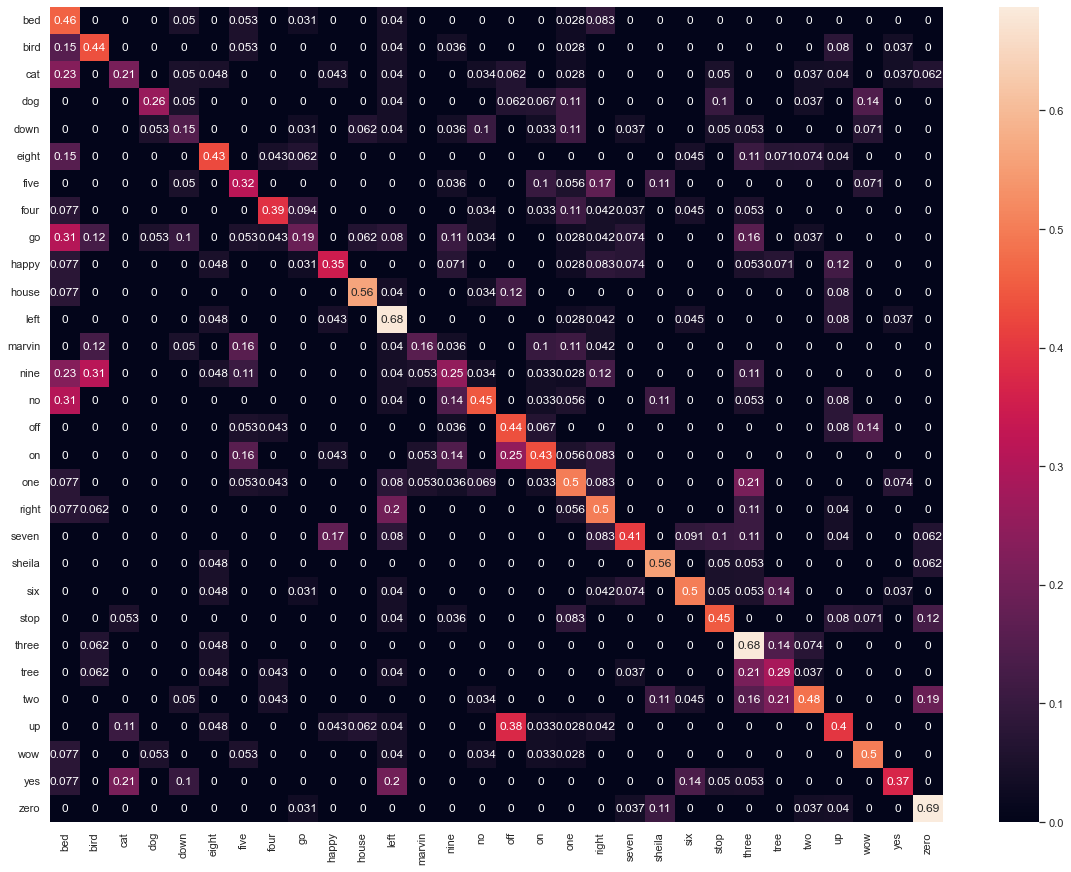

In [95]:
savename = path+plot_extension+"confusion_cnn.pdf"  
cf_matrix = confusion_matrix(expected_label, predicted_label)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,15))
sns.heatmap(df_cm, annot=True)
plt.savefig(savename, bbox_inches='tight')

In [ ]:
# Change here the name of the categories

torch.manual_seed(64)

class_mapping = list(classes)

def predict(model, inputs, target, class_mapping):
    model.eval()
    with torch.no_grad():
        predictions = model(inputs)
        # Tensor (1, 10) -> [ [0.1, 0.01, ..., 0.6] ]
        predicted_index = predictions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected

# load back the model
# cnn = CNNNetwork()
# state_dict = torch.load(DATA_PATH + "cnn2.pth")
# cnn.load_state_dict(state_dict)

# get a sample from the validation dataset for inference
z = 0
inputs, target = crd_validation[z][0], crd_validation[z][1]
inputs.unsqueeze_(0)

# make an inference
predicted, expected = predict(cnn, inputs, target,
                                  class_mapping)
print(f"Predicted: '{predicted}', expected: '{expected}'")

In [ ]:
count = 0
for z in range(len(crd_validation)):
    inputs, target = crd_validation[z][0], crd_validation[z][1]
    inputs.unsqueeze_(0)
    predicted, expected = predict(cnn, inputs, target,
                                  class_mapping)
    if predicted == expected:
        count += 1
accuracy = count / len(crd_validation)

In [ ]:
accuracy

In [ ]:
accuracy = pd.Series(accuracy)
auxiliary_folder = "CALIBRATION/"
accuracy.to_csv(path_or_buf=path+auxiliary_folder+"accuracy_10_001.csv", sep=',', index=False)

In [ ]:
# normally you should pass each of them in a constructor to optimize each parameter